## Mounting Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

---
## Importing Packages

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel
import torchvision
from tqdm import tqdm
# from google.colab import files
# from google.colab import drive

2025-08-26 03:22:44.320120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756178564.509843      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756178564.566502      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Defining Paths

In [2]:
# Base path for Kaggle dataset
base_path = '/kaggle/input/hate-speech-multimodal/dataset'

# Train Path
no_hate_path = os.path.join(base_path, 'Subtask A Train/No Hate')
hate_path = os.path.join(base_path, 'Subtask A Train/Hate')
train_text_path_A = os.path.join(base_path, 'Train Text/STask_A_train.csv')

# Val Path
val_path_A = os.path.join(base_path, 'STask_A_val_img')
val_text_path_A = os.path.join(base_path, 'Eval Data Text/STask-A(index,text)val.csv')
val_path_A_label = os.path.join(base_path, 'Eval Data Labels/STask-A(index,label)val.csv')

# Test Path
test_path_A = os.path.join(base_path, 'STask_A_test_img')
test_text_path_A = os.path.join(base_path, 'STask-A(index,text)test.csv')

----
## 2. Dataset

### 2.1 Defining Images as List

In [3]:
# List files in No Hate folder
no_hate_files = os.listdir(no_hate_path)
print(f"Number of files in No Hate folder: {len(no_hate_files)}")
print(f"First few files in No Hate: {no_hate_files[:5]}")

print('---------------')

# List files in Hate folder
hate_files = os.listdir(hate_path)
print(f"Number of files in Hate folder: {len(hate_files)}")
print(f"First few files in Hate: {hate_files[:5]}")

print('---------------')

val_files = os.listdir(val_path_A)
print(f"Number of files in VAL folder: {len(val_files)}")
print(f"First few files in VAL: {val_files[:5]}")

print('---------------')

test_files = os.listdir(test_path_A)
print(f"Number of files in VAL folder: {len(test_files)}")
print(f"First few files in VAL: {test_files[:5]}")

Number of files in No Hate folder: 2065
First few files in No Hate: ['9273.png', '9292.png', '4353.png', '6262.png', '2664.png']
---------------
Number of files in Hate folder: 1985
First few files in Hate: ['5511.png', '9703.png', '5703.png', '3217.png', '2673.png']
---------------
Number of files in VAL folder: 506
First few files in VAL: ['7197.png', '6692.png', '7418.png', '8343.png', '2619.png']
---------------
Number of files in VAL folder: 507
First few files in VAL: ['5695.png', '2851.png', '3448.png', '8987.png', '4649.png']


### 2.2 Converting that list into Dataframe

In [4]:
import pandas as pd

# Collect file paths and labels
train_data = []
val_data = []
test_data = []

for file in no_hate_files:
    train_data.append([os.path.join(no_hate_path, file),file, 0])  # 0 for No Hate
for file in hate_files:
    train_data.append([os.path.join(hate_path, file),file, 1])  # 1 for Hate
for file in val_files:
    val_data.append([os.path.join(val_path_A, file),file])
for file in test_files:
    test_data.append([os.path.join(test_path_A, file),file])


# Create a DataFrame
train_img_df = pd.DataFrame(train_data, columns=['image_path','index','label'])
train_text_df = pd.read_csv(train_text_path_A)

val_img_df = pd.DataFrame(val_data, columns=['image_path','index'])
val_text_df = pd.read_csv(val_text_path_A)
val_label_df = pd.read_csv(val_path_A_label)

test_img_df = pd.DataFrame(test_data, columns=['image_path','index'])
test_text_df = pd.read_csv(test_text_path_A)

### 2.3 Merging training dataframe (`img_df`, `text_df`)

In [6]:
print(f"Shape of train_img_df: {train_img_df.shape}")
print(f"Shape of train_text_df: {train_text_df.shape}")

Shape of train_img_df: (4050, 3)
Shape of train_text_df: (4050, 3)


In [7]:
merged_train_df = pd.merge(train_img_df, train_text_df, on='index', how='left', suffixes=('', '_drop'))

merged_train_df = merged_train_df.loc[:, ~merged_train_df.columns.str.endswith('_drop')]

In [8]:
merged_train_df.head()

,image_path,index,label,text
0,/kaggle/input/hate-speech-multimodal/dataset/S...,9273.png,0,uncispecting boy mode girl mode 14
1,/kaggle/input/hate-speech-multimodal/dataset/S...,9292.png,0,do i want or do i want to date them to be them...
2,/kaggle/input/hate-speech-multimodal/dataset/S...,4353.png,0,the four trans pokemon azurill can change thei...
3,/kaggle/input/hate-speech-multimodal/dataset/S...,6262.png,0,meeting my past selves 20 year old self l 5 ye...
4,/kaggle/input/hate-speech-multimodal/dataset/S...,2664.png,0,twitter thanking me for supporting lgbt rights...


In [9]:
merged_train_df.shape

(4050, 4)


### 2.4 Merging validation dataframe (`img_df`, `text_df`, `label_df`)


In [10]:
print(f"Shape of val_img_df: {val_img_df.shape}")
print(f"Shape of val_text_df: {val_text_df.shape}")
print(f"Shape of val_label_df: {val_label_df.shape}")

Shape of val_img_df: (506, 2)
Shape of val_text_df: (506, 2)
Shape of val_label_df: (506, 2)


In [11]:
merged_df = pd.merge(val_img_df, val_text_df, on='index', how='left', suffixes=('', '_drop'))

merged_df = pd.merge(merged_df, val_label_df, on='index', how='left', suffixes=('', '_drop'))

merged_val_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_drop')]

In [12]:
merged_val_df.head()

,image_path,index,text,label
0,/kaggle/input/hate-speech-multimodal/dataset/S...,7197.png,quiztest me rchy 198 funny quiz your favorite ...,0
1,/kaggle/input/hate-speech-multimodal/dataset/S...,6692.png,no i'm not your gay best friend no i'm not con...,0
2,/kaggle/input/hate-speech-multimodal/dataset/S...,7418.png,which one is pedophilia being sexually assault...,1
3,/kaggle/input/hate-speech-multimodal/dataset/S...,8343.png,florida just keeps getting better 472 154 comm...,1
4,/kaggle/input/hate-speech-multimodal/dataset/S...,2619.png,tim pool retweeted matt walsh attwalshblog dyl...,1


In [13]:
merged_val_df.shape

(506, 4)


### 2.5 Merging test dataframe (`img_df`, `text_df`)


In [14]:
print(f"Shape of test_img_df: {test_img_df.shape}")
print(f"Shape of test_text_df: {test_text_df.shape}")

Shape of test_img_df: (507, 2)
Shape of test_text_df: (507, 2)


In [15]:
merged_test_df = pd.merge(test_img_df, test_text_df, on='index', how='left', suffixes=('', '_drop'))

merged_test_df = merged_test_df.loc[:, ~merged_test_df.columns.str.endswith('_drop')]

In [16]:
merged_test_df.head()

,image_path,index,text
0,/kaggle/input/hate-speech-multimodal/dataset/S...,5695.png,mgflip com my cus is hosting a dinner to celeb...
1,/kaggle/input/hate-speech-multimodal/dataset/S...,2851.png,covid happening church i bet the gays did this
2,/kaggle/input/hate-speech-multimodal/dataset/S...,3448.png,he she is' they are
3,/kaggle/input/hate-speech-multimodal/dataset/S...,8987.png,creator zez gnomioilha ma 3469 2989 4664 do yo...
4,/kaggle/input/hate-speech-multimodal/dataset/S...,4649.png,trans rights are human rights


In [17]:
merged_test_df.shape

(507, 3)


### 2.5 Visualize the Input: **IMAGE & TEXT**

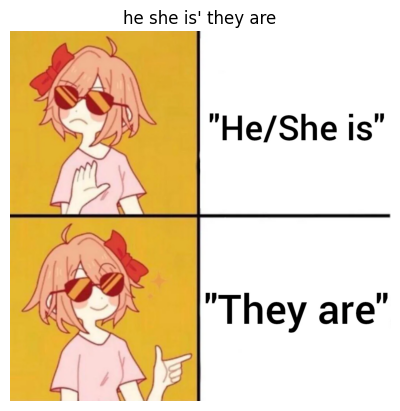

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

# Get the first image path from merged_df
first_image_path = merged_test_df['image_path'].iloc[2]

# Load and display the image
img = Image.open(first_image_path)
plt.imshow(img)
plt.title(merged_test_df['text'].iloc[2])
plt.axis('off')
plt.show()

### Dataset Defined & Combined
**Datasets:**
- `merged_val_df`
- `merged_train_df`
- `merged_test_df`

---
## 3. Designing Custom Dataset

In [ ]:
HF_TOKEN = '***********************'


### 3.1 Custom Train Multimodel Dataset

In [20]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = 128  # Max length for text tokens

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        text = str(self.dataframe.iloc[idx]['text'])
        label = self.dataframe.iloc[idx]['label']

        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize text
        encoding = self.tokenizer(text, max_length=self.max_length, padding='max_length',
                                 truncation=True, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return image, input_ids, attention_mask, label

### 3.2 Custom Test Multimodel Datase

In [21]:
class TestMultimodalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = 128  # Max length for text tokens

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        text = str(self.dataframe.iloc[idx]['text'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)
        index = self.dataframe.iloc[idx]['index']  # Return index (e.g., "9444.png")
        return image, input_ids, attention_mask, index

### 3.2 Defining Transforms & Datasets

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet norms
])

In [23]:
train_dataset = MultimodalDataset(merged_train_df, transform=transform)
val_dataset = MultimodalDataset(merged_val_df, transform=transform)
test_dataset = TestMultimodalDataset(merged_test_df, transform=transform)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### 3.3 Create dataloaders

In [24]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

---
## 4. Defining the Model

### 4.1 MultimodalResNetBERT Model

In [25]:
class MultimodalResNetBERT(nn.Module):
    def __init__(self, num_classes=2):
        super(MultimodalResNetBERT, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.image_fc = nn.Linear(512, 256)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(768, 256)
        self.fc = nn.Linear(256 * 2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Increased dropout for regularization

    def forward(self, images, input_ids, attention_mask):
        image_features = self.resnet(images)
        image_features = self.relu(self.image_fc(image_features))
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output
        text_features = self.relu(self.text_fc(text_features))
        combined_features = torch.cat((image_features, text_features), dim=1)
        combined_features = self.dropout(combined_features)
        output = self.fc(combined_features)
        return output

---
## 5. Initialize model, loss, and optimizer

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalResNetBERT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)  # Lower LR and add weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s] 


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

----
## 6. Function to plot training metrics

In [27]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import gc

In [28]:
# Plotting function
def plot_metrics(train_losses, train_f1_scores, train_accuracies, train_aucs, val_losses, val_f1_scores, val_accuracies, val_aucs, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(15, 5))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot F1 Score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_f1_scores, 'b-', label='Training F1 Score')
    plt.plot(epochs, val_f1_scores, 'r-', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plot Accuracy and AUC
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.plot(epochs, train_aucs, 'g-', label='Training AUC')
    plt.plot(epochs, val_aucs, 'y-', label='Validation AUC')
    plt.title('Training and Validation Accuracy & AUC')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [29]:
# Initialize scaler for mixed precision training
scaler = GradScaler()

/tmp/ipykernel_36/3909249703.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast
import gc

# Training function with F1 score and AUC
def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    all_predictions = []
    all_labels = []
    all_probs = []  # For AUC calculation
    for images, input_ids, attention_mask, labels in tqdm(train_loader, desc="Training", unit="batch"):
        images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())  # Detach before converting to numpy
    train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total
    train_f1 = f1_score(all_labels, all_predictions, average='binary')
    train_auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.0  # AUC calculation
    print(f'Training Loss: {train_loss:.4f}, Training F1 Score: {train_f1:.4f}, Training Accuracy: {train_acc:.2f}%, Training AUC: {train_auc:.4f}')
    return train_loss, train_f1, train_acc, train_auc

# Validation function with F1 score and AUC
def evaluate_val(model, val_loader, criterion, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []  # For AUC calculation
    val_loss = 0.0
    with torch.no_grad():
        for images, input_ids, attention_mask, labels in tqdm(val_loader, desc="Validating", unit="batch"):
            images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())  # Detach before converting to numpy
    val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_labels, all_predictions, average='binary')
    val_acc = 100 * sum([p == l for p, l in zip(all_predictions, all_labels)]) / len(all_labels)
    val_auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.0  # AUC calculation
    print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Accuracy: {val_acc:.2f}%, Validation AUC: {val_auc:.4f}')
    return val_loss, val_f1, val_acc, val_auc

---
## 7. Training and Validaton

In [31]:
num_epochs = 20
train_losses = []
train_f1_scores = []
train_accuracies = []
train_aucs = []
val_losses = []
val_f1_scores = []
val_accuracies = []
val_aucs = []
best_val_f1 = 0.0
patience = 3
trigger_times = 0

for epoch in range(num_epochs):
    # Train
    train_loss, train_f1, train_acc, train_auc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)
    train_accuracies.append(train_acc)
    train_aucs.append(train_auc)

    # Validate
    val_loss, val_f1, val_acc, val_auc = evaluate_val(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.2f}%, Train AUC: {train_auc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}")
    print("==========================")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_subtask_a.pth')
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

    scheduler.step(val_loss)
    torch.cuda.empty_cache()
    gc.collect()

Training:   0%|          | 0/254 [00:00<?, ?batch/s]/tmp/ipykernel_36/3333563451.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [01:18<00:00,  3.25batch/s]


Training Loss: 0.6619, Training F1 Score: 0.5864, Training Accuracy: 60.47%, Training AUC: 0.6427


Validating: 100%|██████████| 32/32 [00:10<00:00,  2.91batch/s]


Validation Loss: 0.5511, Validation F1 Score: 0.7607, Validation Accuracy: 74.51%, Validation AUC: 0.8092
Epoch 1: Train Loss: 0.6619, Train F1: 0.5864, Train Acc: 60.47%, Train AUC: 0.6427, Val Loss: 0.5511, Val F1: 0.7607, Val Acc: 74.51%, Val AUC: 0.8092


Training:   0%|          | 0/254 [00:00<?, ?batch/s]/tmp/ipykernel_36/3333563451.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [01:12<00:00,  3.50batch/s]


Training Loss: 0.5253, Training F1 Score: 0.7506, Training Accuracy: 75.51%, Training AUC: 0.8174


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.13batch/s]


Validation Loss: 0.5126, Validation F1 Score: 0.7725, Validation Accuracy: 76.48%, Validation AUC: 0.8299
Epoch 2: Train Loss: 0.5253, Train F1: 0.7506, Train Acc: 75.51%, Train AUC: 0.8174, Val Loss: 0.5126, Val F1: 0.7725, Val Acc: 76.48%, Val AUC: 0.8299


Training:   0%|          | 0/254 [00:00<?, ?batch/s]/tmp/ipykernel_36/3333563451.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [01:15<00:00,  3.37batch/s]


Training Loss: 0.3923, Training F1 Score: 0.8379, Training Accuracy: 84.05%, Training AUC: 0.9061


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.06batch/s]


Validation Loss: 0.5393, Validation F1 Score: 0.7448, Validation Accuracy: 73.32%, Validation AUC: 0.8188
Epoch 3: Train Loss: 0.3923, Train F1: 0.8379, Train Acc: 84.05%, Train AUC: 0.9061, Val Loss: 0.5393, Val F1: 0.7448, Val Acc: 73.32%, Val AUC: 0.8188


Training:   0%|          | 0/254 [00:00<?, ?batch/s]/tmp/ipykernel_36/3333563451.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [01:13<00:00,  3.46batch/s]


Training Loss: 0.2543, Training F1 Score: 0.9120, Training Accuracy: 91.41%, Training AUC: 0.9564


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.14batch/s]


Validation Loss: 0.6483, Validation F1 Score: 0.7167, Validation Accuracy: 73.12%, Validation AUC: 0.8172
Epoch 4: Train Loss: 0.2543, Train F1: 0.9120, Train Acc: 91.41%, Train AUC: 0.9564, Val Loss: 0.6483, Val F1: 0.7167, Val Acc: 73.12%, Val AUC: 0.8172


Training:   0%|          | 0/254 [00:00<?, ?batch/s]/tmp/ipykernel_36/3333563451.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 254/254 [01:12<00:00,  3.49batch/s]


Training Loss: 0.1713, Training F1 Score: 0.9453, Training Accuracy: 94.64%, Training AUC: 0.9799


Validating: 100%|██████████| 32/32 [00:10<00:00,  3.17batch/s]

Validation Loss: 0.6674, Validation F1 Score: 0.7302, Validation Accuracy: 73.72%, Validation AUC: 0.8111
Epoch 5: Train Loss: 0.1713, Train F1: 0.9453, Train Acc: 94.64%, Train AUC: 0.9799, Val Loss: 0.6674, Val F1: 0.7302, Val Acc: 73.72%, Val AUC: 0.8111
Early stopping triggered!


### 7.1 Plotting training and testing metrics

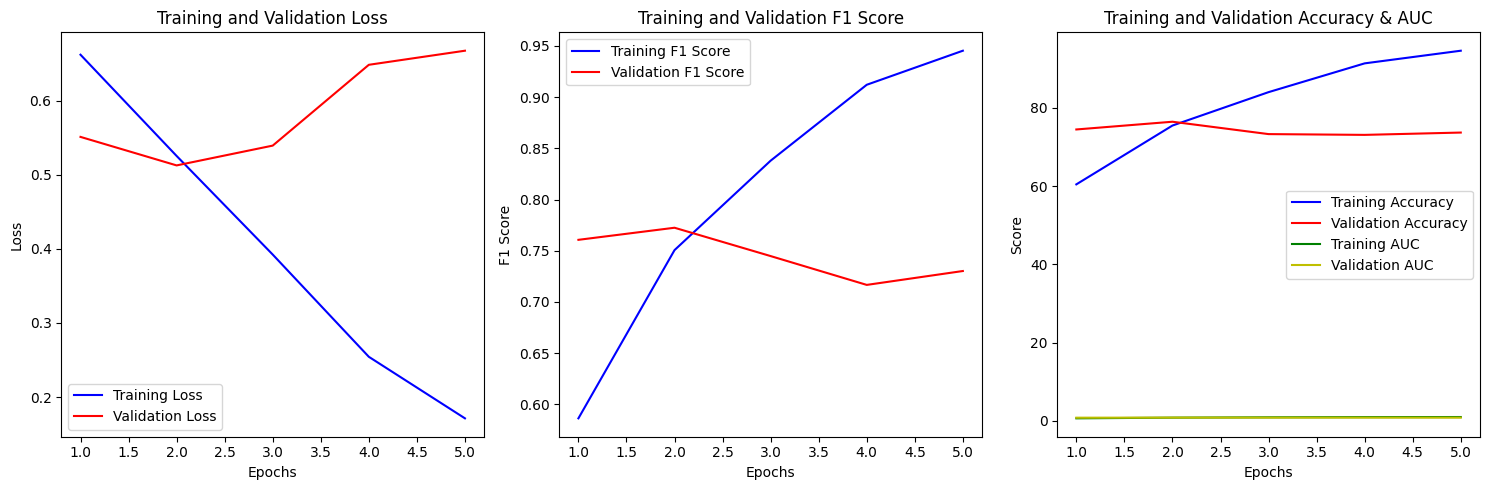

In [32]:
# Plot metrics after training
plot_metrics(train_losses, train_f1_scores, train_accuracies, train_aucs, val_losses, val_f1_scores, val_accuracies, val_aucs, len(train_losses))

In [33]:
# model_save_path = '/kaggle/working/best_model_subtask_a.pth'

In [34]:
print("\nTo download the best model:")
print(f"1. Go to the 'Output' tab in the Kaggle notebook interface.")
print(f"2. Locate '{model_save_path}' in the '/kaggle/working' directory.")
print(f"3. Click the three dots (...) next to the file and select 'Download'.")


To download the best model:
1. Go to the 'Output' tab in the Kaggle notebook interface.


NameError: name 'model_save_path' is not defined

---
## 8. Making prediction

In [ ]:
# model_save_path = '/kaggle/working/best_model_subtask_a.pth'

# # Load the best model
# try:
#     model.load_state_dict(torch.load(model_save_path, map_location=device))
#     print(f"Successfully loaded model from {model_save_path}")
# except FileNotFoundError:
#     print(f"Error: Model file {model_save_path} not found in /kaggle/working. Ensure the model was saved during training.")
#     raise
# except Exception as e:
#     print(f"Error loading model: {e}")
#     raise

In [ ]:
# # Prediction on test set
# model.eval()
# all_predictions = []
# all_indices = []

# with torch.no_grad():
#     for images, input_ids, attention_mask, indices in tqdm(test_loader, desc="Testing", unit="batch"):
#         images = images.to(device)
#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         outputs = model(images, input_ids, attention_mask)
#         _, predicted = torch.max(outputs.data, 1)
#         all_predictions.extend(predicted.cpu().numpy())
#         all_indices.extend(indices)

In [ ]:
import json

In [ ]:
# submission = [{"index": idx, "prediction": int(pred)} for idx, pred in zip(all_indices, all_predictions)]
# submission = sorted(submission, key=lambda x: x["index"])

# # Save submission to JSON file in Kaggle's working directory
# submission_json_path = '/kaggle/working/submission.json'
# with open(submission_json_path, "w") as f:
#     json.dump(submission, f)
# print(f"Submission JSON saved to {submission_json_path}")

# # Zip the submission file
# zip_path = '/kaggle/working/ref.zip'
# os.system(f"zip {zip_path} {submission_json_path}")
# print(f"Submission zipped to {zip_path}")